In [22]:
import pandas as pd
import numpy as np
import os
import boto3 

### import Data

In [23]:
df = pd.read_csv('train_dataset2.csv')

In [24]:
x = df.iloc[:,1:-2]
y = df.iloc[:,-2:]

In [25]:
x.head()

,most_freq_dow,most_freq_hour,median_create_session_time,session_count,session_durations,mean_session_durations,mean_session_interval,most_freq_country,most_freq_region,most_freq_city,...,purchase_per_active_day,session_per_day,purchase_per_day,user_entropy,last_session_time,last_purchase_time,country_mean_purchase_perc,os_mean_purchase_perc,cost_per_purchase,attr_11
0,6,7,36.0,46,938183565,2.039529e+07,0.782609,162,0,13840,...,0.055556,0.851852,0.018519,3.828641,1,19,0.005269,0.028374,2.2465,3.49
1,5,23,0.0,3,6074816,2.024939e+06,0.000000,69,281,22738,...,0.000000,3.000000,0.000000,1.098612,20,100,0.060754,0.078831,1.0000,0.01
2,2,22,0.0,1,0,0.000000e+00,0.000000,210,299,3615,...,0.000000,0.000000,0.000000,0.000000,45,100,0.068370,0.078831,1.0000,0.00
3,3,15,2.0,1,596967,5.969670e+05,2.000000,94,162,8967,...,0.000000,0.250000,0.000000,0.693147,9,100,0.004529,0.028374,1.0000,0.00
4,2,2,0.5,1,97482,9.748200e+04,0.500000,11,494,22898,...,0.000000,1.000000,0.000000,0.693147,38,100,0.067344,0.028374,1.0000,0.00


In [26]:
y_7_days = y.user_purchase_binary_7_days
y_14_days = y.user_purchase_binary_14_days

In [27]:
y_14_days.value_counts()

0.0    613607
1.0      6099
Name: user_purchase_binary_14_days, dtype: int64

### Train_Validation_split

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=42)

In [30]:
y_train_7_days = y_train.user_purchase_binary_7_days
y_train_14_days = y_train.user_purchase_binary_14_days
y_valid_7_days = y_valid.iloc[:,:1]
y_valid_14_days = y_valid.iloc[:,-1]

### Tune hyperparameter

In [31]:
import xgboost as xgb

In [ ]:
# model for 7 days
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipe_lgbm = Pipeline([('xgbm', xgb.XGBClassifier(random_state = 42,n_jobs =-1, verbose=3))]) 

grid_params = { 'xgbm__learning_rate': [0.005, 0.01],'xgbm__n_estimators': [50,100],
                'xgbm__num_leaves': [10,31,50], 'xgbm__class_weight':['balanced', None]}
    
gridSearch = GridSearchCV(estimator=pipe_lgbm,param_grid=grid_params, cv = 5,  scoring='roc_auc')

gridSearch.fit(x_train.values, y_train_7_days.values.ravel())
best_params = gridSearch.best_params_
print(best_params)
print(gridSearch.best_score_)

In [32]:
from sklearn.metrics import roc_auc_score
model = xgb.XGBClassifier(n_jobs =-1, verbose=3, class_weight='balanced', 
                           learning_rate=0.25, n_estimators=200)
model.fit(x_train.values,y_train_7_days.values.ravel())
valid_pred = model.predict_proba(x_valid.values)
roc_auc_score(y_valid_7_days,valid_pred[:,-1])

0.9970214485430039

In [33]:
pd.DataFrame(model.feature_importances_,x_train.columns)

,0
most_freq_dow,0.007347
most_freq_hour,0.022857
median_create_session_time,0.023673
session_count,0.021224
session_durations,0.026939
mean_session_durations,0.042449
mean_session_interval,0.024490
most_freq_country,0.017959
most_freq_region,0.026939
most_freq_city,0.047347


In [35]:
model2 = xgb.XGBClassifier(n_jobs =-1, verbose=3, class_weight='balanced', 
                           learning_rate=0.25, n_estimators=200)
model2.fit(x_train.values,y_train_14_days.values.ravel())
valid_pred2 = model2.predict_proba(x_valid.values)
roc_auc_score(y_valid_14_days,valid_pred2[:,-1])

0.9974930698358082

In [37]:
pd.DataFrame(model2.feature_importances_,x_train.columns)

,0
most_freq_dow,0.009740
most_freq_hour,0.019481
median_create_session_time,0.014610
session_count,0.018669
session_durations,0.026786
mean_session_durations,0.052760
mean_session_interval,0.023539
most_freq_country,0.012987
most_freq_region,0.018669
most_freq_city,0.025162


### Predict on the full trainset

In [38]:
test = pd.read_csv('test_feature2.csv')

In [39]:
user = test.user_id_hash
x_test = test.iloc[:,1:]

In [40]:
# 7 days
xgb_7days = xgb.XGBClassifier(n_jobs =-1, verbose=3, class_weight='balanced', 
                           learning_rate=0.25, n_estimators=200)
xgb_7days.fit(x.values,y_7_days.values.ravel())
y_7_days_pred = xgb_7days.predict_proba(x_test.values)

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
features = list(x.columns)
importances = xgb_7days.feature_importances_
indices = np.argsort(importances)[::-1][:10]

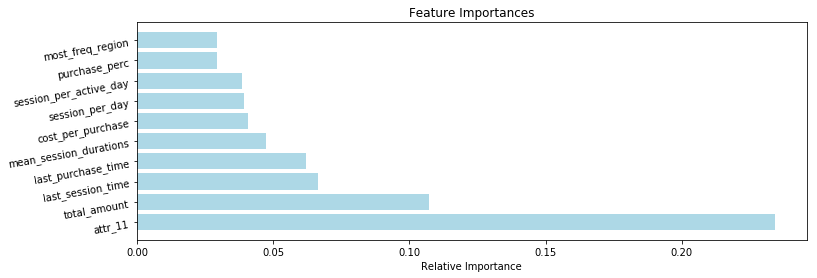

In [53]:
fig = plt.figure(figsize=(12,4)) 
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='lightblue', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices],rotation=10)
plt.xlabel('Relative Importance')
plt.show()
fig.savefig('random_forst_feature_importance_for_7days')

In [41]:
# 14 days
xgb_14days = xgb.XGBClassifier(n_jobs =-1, verbose=3, class_weight='balanced', 
                           learning_rate=0.25, n_estimators=200)
xgb_14days.fit(x.values,y_14_days.values.ravel())
y_14_days_pred = xgb_14days.predict_proba(x_test.values)

In [55]:
features = list(x.columns)
importances = xgb_14days.feature_importances_
indices = np.argsort(importances)[::-1][:10]

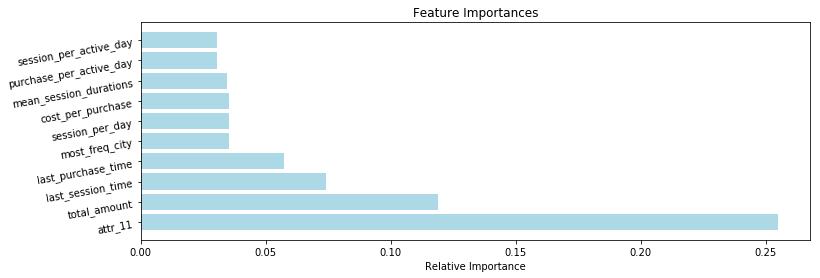

In [56]:
fig2 = plt.figure(figsize=(12,4)) 
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='lightblue', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices],rotation=10)
plt.xlabel('Relative Importance')
plt.show()

In [42]:
d = {'user_id_hash': user, 'user_purchase_binary_7_days': y_7_days_pred[:,-1], 'user_purchase_binary_14_days': y_14_days_pred[:,-1]}

In [43]:
predictions = pd.DataFrame(data=d)

In [44]:
predictions.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days
0,e469dfaed039ead9110165d9bc457acb11609ca34057dc...,2.788838e-06,2.774862e-06
1,afcc639a324b6c598ef83d360450afa011cb2dd1358bf9...,4.237786e-03,1.063714e-02
2,fd5a7cf211d08e3e00f7be6a9df6e6ea3d2e5c22a5d9c3...,3.395291e-06,2.711920e-06
3,00bfff98b9d0329f014c2eeac7ce47cd18b2bc6e10d608...,1.605718e-06,1.058060e-05
4,0d298f3638c43e915c119d4935e1ce8d168f81b5e3e8c1...,1.498373e-07,1.716015e-07


In [45]:
predictions.to_csv('submission2.csv', index=False)

In [21]:
pd.DataFrame(xgb_7days.feature_importances_,x.columns)

,0
most_freq_dow,0.008661
most_freq_hour,0.021260
median_create_session_time,0.018110
session_count,0.036220
session_durations,0.038583
mean_session_durations,0.063780
mean_session_interval,0.020472
most_freq_country,0.017323
most_freq_region,0.024409
most_freq_city,0.032283
